### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    Aditya Desu

**Student ID:**     

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


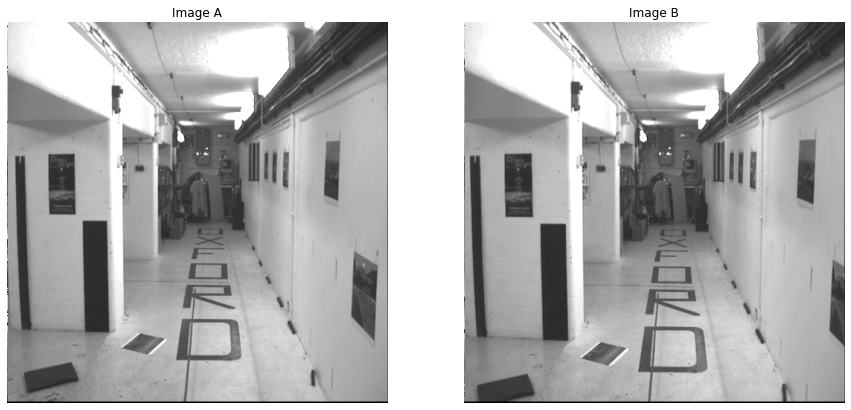

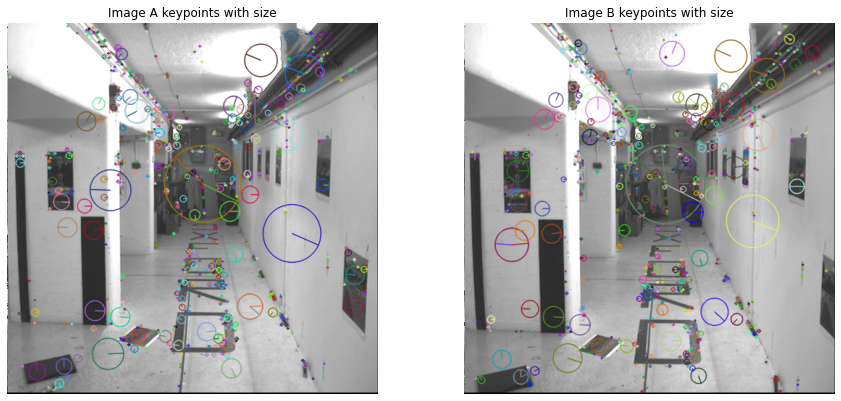

Number of keypoints detected in the Scene image:  702
Number of matches:  395


In [189]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

def load_image(imageA, imageB):
    # Load images
    data_dir = '/Users/adityadesu/Documents/Computer Vision/Assignment 3/kusvod2'

    imageA = cv2.imread(os.path.join(data_dir, imageA), cv2.IMREAD_GRAYSCALE)
    imageB = cv2.imread(os.path.join(data_dir, imageB), cv2.IMREAD_GRAYSCALE)
    return imageA,imageB

imageA, imageB = load_image('corrA.png', 'corrB.png')


def display_original_img(imageA, imageB, titleA, titleB):
    # Display original image and scene image
    plt.subplots(figsize=(15, 15)) 

    plt.subplot(1,2,1)
    plt.imshow(imageA, cmap='gray') 
    plt.title(titleA)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(imageB, cmap='gray')
    plt.title(titleB)
    plt.axis('off')

    plt.show()

display_original_img(imageA, imageB,'Image A', 'Image B')

# Initiate SIFT detector
sift = cv2.SIFT_create()  

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imageA,None)
kp2, des2 = sift.detectAndCompute(imageB,None)

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(imageA,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(imageB,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplots(figsize=(15, 15)) 
plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Image A keypoints with size')
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Image B keypoints with size')
plt.axis('off')
plt.show() 

print("Number of keypoints detected in the Scene image: ", len(kp2))

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.7 *n.distance: 
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)



ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)


print("Number of matches: ", len(ptsL))

# Add ones to the end of the points
ptsL_mat = np.hstack((ptsL, np.ones((ptsL.shape[0], 1))))
ptsR_mat = np.hstack((ptsR, np.ones((ptsR.shape[0], 1))))



### 2. Compute the Fundamental Matrix F using the 8 point algorithm

Number of RANSAC inliers: 1204
Number of inliers: 357
Number of outliers: 38
F after Ransac Loop:
 [[ 1.72030296e-08  5.84303678e-05 -1.09495054e-02]
 [-5.84542560e-05  4.68188426e-08  1.28726888e-02]
 [ 1.09501724e-02 -1.32879940e-02  7.61595453e-02]]


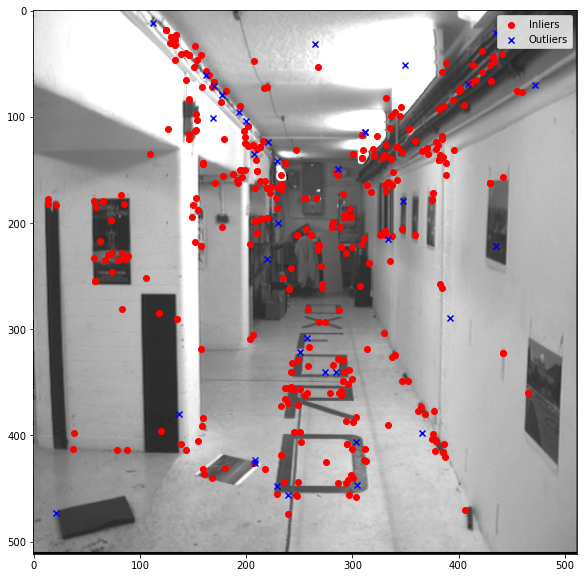

In [192]:
def normalize(pts):
    ''' Shift and transform points to have root 2 mean and unit variance 
        params:
            pts: points to be normalized
        returns:
            pts_norm: normalized points'''
    n = len(pts)
    centroid = np.mean(pts, axis=0)
    centered_coords = pts - centroid
    scaling_f = n*np.sqrt(2)/np.sum(np.linalg.norm(centered_coords, axis=1))
    T = np.array([[scaling_f, 0, -scaling_f*centroid[0]], 
                [0, scaling_f, -scaling_f*centroid[1]], 
                [0, 0, 1]])
    normalised_pts = pts.copy()
    for i in range(n):
        normalised_pts[i] = T @ pts[i]
    
    return normalised_pts, T

normalised_pts1, T1 = normalize(ptsL_mat)
normalized_pts2, T2 = normalize(ptsR_mat)


def get_design_matrix(ptsL, ptsR, idx):
    ''' Return a design matrix for the 8 point algorithm 
        params:
            ptsL: points in the left image
            ptsR: points in the right image
            idx: indices of the points to be used
            returns:
                A: design matrix'''
    n = len(idx)
    
    
    A = np.zeros((n, 9))
    for i,x in enumerate(idx):
        design_matrix_row = np.array([ptsL[x, 0]*ptsR[x, 0], ptsL[x, 1]*ptsR[x, 0], ptsR[x, 0], 
                                    ptsL[x, 0]*ptsR[x, 1], ptsL[x, 1]*ptsR[x, 1], ptsR[x, 1], 
                                    ptsL[x, 0], ptsL[x, 1], 1])

        A[i] = design_matrix_row
        
    return A

def get_fundamental_matrix(A):
    ''' Return the fundamental matrix using the 8 point algorithm 
        params:
            A: design matrix
            returns:
                F: fundamental matrix'''

    U, S, V = np.linalg.svd(A)
    F = V[-1, :].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ V
    return F


def compute_epilines(F, pts, inliers, right):
    ''' Return the epilines for a given set of F, points and inliers 
        If right is True, compute the epilines for the right image, otherwise for the left image
        params:
            F: fundamental matrix
            pts: points
            inliers: inliers
            right: boolean
            returns:
                epilines: epilines'''
    epilines = []
    if right:
        for i in inliers:
            x = np.array([pts[i, 0], pts[i, 1], 1])
        
            epiline = np.matmul(F, x)
            epilines.append(epiline)
        return np.array(epilines)
    else:
        for i in inliers:
            x = np.array([pts[i, 0], pts[i, 1], 1])
            epiline = np.matmul(F.T, x)
            epilines.append(epiline)
        return np.array(epilines)

# Compute inlers and outliers
def get_inliers_outliers(ptsL, ptsR, F, threshold):
    ''' Return inliers and outliers given a fundamental matrix, a threshold and a set of points 
    params: 
        ptsL: points in the left image
        ptsR: points in the right image
        F: fundamental matrix
        threshold: threshold
        returns:
            inliers: inliers'''
    inliers = []
    outliers = []
    epipolar_lines_right = []
   

    for i in range(len(ptsL)):
        x1 = np.array([ptsL[i, 0], ptsL[i, 1], 1])
        x2 = np.array([ptsR[i, 0], ptsR[i, 1], 1])
        # Compute epipolar line for both images
        epipolar_line_right = np.dot(F, x1)
        
        epipolar_lines_right.append(epipolar_line_right)
        
        
        a, b, c = epipolar_line_right

        # Compute distance from point to epipolar line
        d1 = abs(x1 @ epipolar_line_right) / np.linalg.norm(epipolar_line_right[:2])
        d2 = abs((a * x2[0] + b * x2[1] + c) / (np.sqrt(a**2 + b**2)))
        #print(d2)
        if d2 < threshold:
            inliers.append(i)
        else:
            outliers.append(i)
    
    return inliers, outliers


# Combine above functions within a RANSAC loop
def ransac(ptsL, ptsR, threshold, n_iterations):
    ''' Return the fundamental matrix using RANSAC 
    params:
        ptsL: points in the left image
        ptsR: points in the right image
        threshold: threshold
        n_iterations: number of iterations
        returns:
            F: fundamental matrix
            inliers: inliers
            outliers: outliers'''
    best_F = None
    best_inliers = None
    best_outliers = None
    best_inliers_count = 0
    ratio = 0
    n = len(ptsL)

    for i in range(n_iterations):
        # Randomly sample 8 points
        idx = np.random.choice(n, 8, replace=False)
        
        # Compute the fundamental matrix
        ptsL_normalised, T1 = normalize(ptsL)
        ptsR_normalised, T2 = normalize(ptsR)
        A = get_design_matrix(ptsL_normalised, ptsR_normalised, idx)
        draft_F = get_fundamental_matrix(A)
        
        # Rescale the fundamental matrix
        F = T2.T @ draft_F @ T1
        
        # Compute inliers and outliers
        inliers, outliers = get_inliers_outliers(ptsL, ptsR, F, threshold)
        
        # Update best F and inliers
        if len(inliers)/len(ptsL) > ratio:
            best_F = F
            best_inliers = inliers
            ratio = len(inliers)/len(ptsL)
            best_outliers = outliers
            best_inliers_count = len(inliers)

         
        
    return best_F, best_inliers, best_outliers

# Run RANSAC
best_F, best_inliers, best_outliers = ransac(ptsL_mat, ptsR_mat, 1, 1204)
print("Number of RANSAC inliers: 1204")
print("Number of inliers:", len(best_inliers))
print("Number of outliers:", len(best_outliers))

# Derive F from the best inliers
ptsL_normalised, T1 = normalize(ptsL_mat)
ptsR_normalised, T2 = normalize(ptsR_mat)
A = get_design_matrix(ptsL_normalised, ptsR_normalised, best_inliers)
F = get_fundamental_matrix(A)

# Rescale the fundamental matrix
F = T2.T @ F @ T1
print("F after Ransac Loop:\n", F)


# Plot inliers and outliers
plt.figure(figsize=(10, 10))
plt.imshow(imageA, cmap='gray')
plt.scatter(ptsL[best_inliers, 0], ptsL[best_inliers, 1], c='r', marker='o', label='Inliers')
plt.scatter(ptsL[best_outliers, 0], ptsL[best_outliers, 1], c='b', marker='x', label='Outliers')
plt.legend()
plt.show()

 


### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

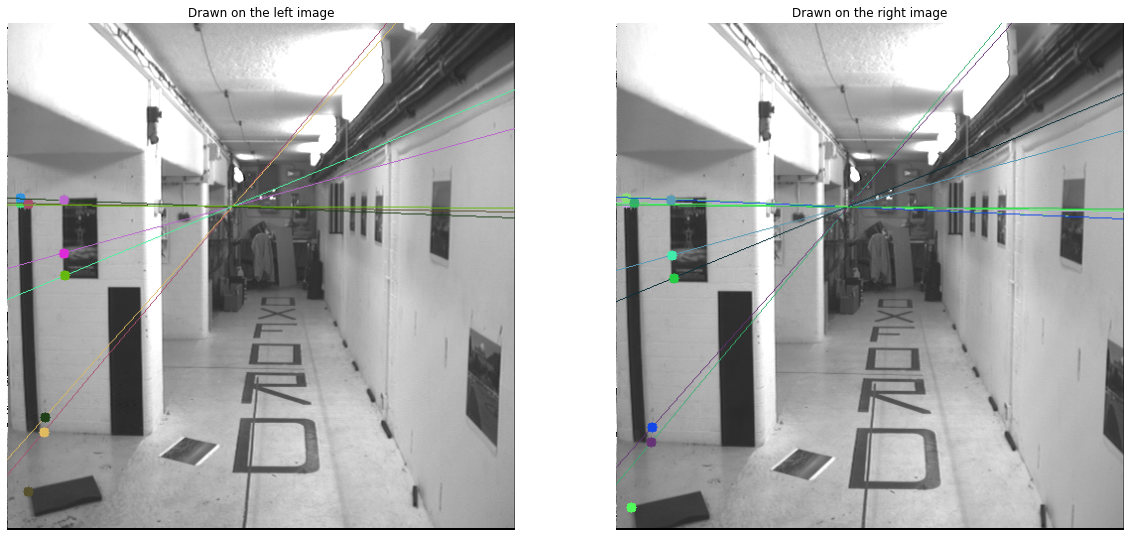

In [191]:

# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' Draw epilines on the images
    params:
        img1: image 1
        img2: image 2
        lines: epilines
        pts1: points in image 1
        pts2: points in image 2
        returns:
            img1: image 1
            img2: image 2'''
    
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2




def display_best_inliers(imageA, imageB, ptsL, ptsR, best_inliers):
    ''' Display the best inliers
    params:
        imageA: image 1
        imageB: image 2
        ptsL: points in image 1
        ptsR: points in image 2
        best_inliers: best inliers
        returns:
            None'''

    # Select the random inliers
    random_idx = np.random.choice(len(best_inliers), 8, replace=False)

    # Get the epilines
    linesL = compute_epilines(best_F, ptsR, best_inliers[:10], False)

    linesL = linesL.reshape(-1,3)
    img5, img6 = drawlines(imageA, imageB, linesL, ptsL, ptsR)

    # Find epilines corresponding to points in left image 
    # and draw its lines on right image
    linesR = compute_epilines(best_F, ptsL, best_inliers[:10], True)
    linesR = linesR.reshape(-1,3)
    img3, img4 = drawlines(imageB, imageA, linesR, ptsR, ptsL)

    # Display the results
    plt.subplots(figsize=(20, 20)) 

    plt.subplot(1,2,1)
    plt.imshow(img5, cmap='gray')  
    plt.title('Drawn on the left image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(img3, cmap='gray')  
    plt.title('Drawn on the right image')
    plt.axis('off')

    plt.show()



display_best_inliers(imageA, imageB, ptsL, ptsR, best_inliers)